# Recurrent neural network

## MANUAL

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Parameters
num_inputs = 2
num_neurons = 3

In [4]:
# Placeholders
x0 = tf.placeholder(tf.float32, [None, num_inputs])
x1 = tf.placeholder(tf.float32, [None, num_inputs])

In [5]:
# Variables
Wx = tf.Variable(tf.random_normal(shape=[num_inputs, num_neurons]))
Wy = tf.Variable(tf.random_normal(shape=[num_neurons, num_neurons]))
b = tf.Variable(tf.zeros([num_neurons]))

In [6]:
# Create cells
y0 = tf.tanh(tf.matmul(x0, Wx) + b)
y1 = tf.tanh(tf.matmul(y0, Wy) + tf.matmul(x1, Wx)+ b)

In [8]:
# Timestamp 0
x0_batch = np.array([[0, 1], [2, 3], [4, 5]])

# Timestamp 1
x1_batch = np.array([[100, 101], [102, 103], [104, 105]])

In [18]:
# Initializer
init = tf.global_variables_initializer()

# Create session
with tf.Session() as sess:
    
    # Run initializer
    sess.run(init)
    
    # Outputs
    y0_output_vals, y1_output_vals = sess.run([y0, y1], feed_dict={x0:x0_batch, x1:x1_batch})

In [19]:
# First cell output
y0_output_vals

array([[-0.5782567 ,  0.5926085 , -0.15328732],
       [-0.9973948 ,  0.95565695, -0.9979758 ],
       [-0.99998724,  0.99598837, -0.9999972 ]], dtype=float32)

In [20]:
# Second cell output
y1_output_vals

array([[-1.,  1., -1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.]], dtype=float32)

## API
### PREPARE DATA

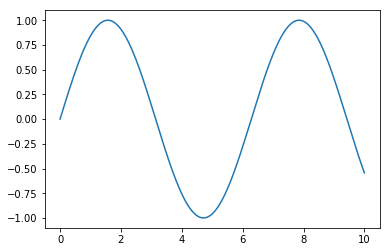

In [21]:
# Create data
class TimeSeriesData():
    def __init__(self,num_points,xmin,xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(
        self,batch_size,steps,return_batch_ts=False):
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1) 
        # Convert to be on time series
        ts_start = rand_start * (
            self.xmax- self.xmin - (steps*self.resolution) )
        # Create batch Time Series on t axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        # Create Y data for time series in the batches
        y_batch = np.sin(batch_ts)
        # Format for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(
                -1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_ts
        else:
            return y_batch[:, :-1].reshape(
                -1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 
        
ts_data = TimeSeriesData(250,0,10)
plt.plot(ts_data.x_data,ts_data.y_true)

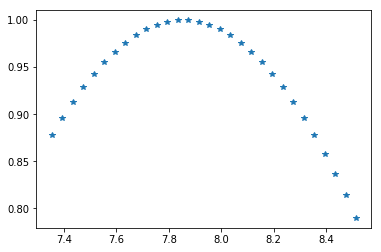

In [22]:
# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 30
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

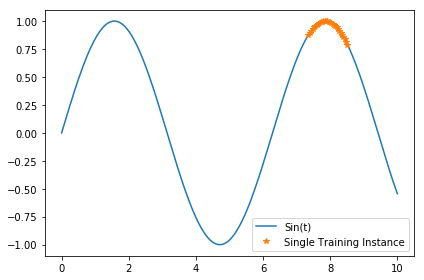

In [24]:
# Plot selected part of sine wave
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training Instance')
plt.legend()
plt.tight_layout()

In [30]:
# Train data
train_inst = np.linspace(5,5 + ts_data.resolution * 
                         (num_time_steps + 1), num_time_steps+1)

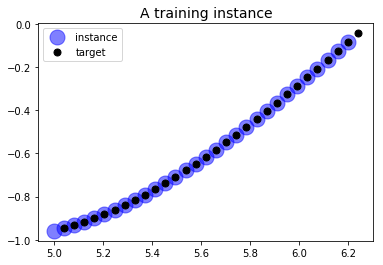

In [31]:
# Plot train data
plt.title("A training instance", fontsize=14)
plt.plot(train_inst[:-1], ts_data.ret_true(
    train_inst[:-1]), "bo", markersize=15,alpha=0.5 ,label="instance")
plt.plot(train_inst[1:], ts_data.ret_true(
    train_inst[1:]), "ko", markersize=7, label="target")
plt.legend()

### CREATE THE MODEL

In [32]:
# Reset graph
tf.reset_default_graph()
# One feature, the time series
num_inputs = 1
# 100 neuron layer
num_neurons = 100
# One output, predicted time series
num_outputs = 1
# Learning rate
learning_rate = 0.0001
# Number of iterations
num_train_iterations = 2000
# Size of the batch of data
batch_size = 1

In [33]:
# Placeholders
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [34]:
# Create cell

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)
"""
cell = tf.contrib.rnn.OutputProjectionWrapper(
     tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
     output_size=num_outputs)    

n_neurons = 100
n_layers = 3

cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
           for layer in range(n_layers)])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)

n_neurons = 100
n_layers = 3

cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
           for layer in range(n_layers)])
"""

'\ncell = tf.contrib.rnn.OutputProjectionWrapper(\n     tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),\n     output_size=num_outputs)    \n\nn_neurons = 100\nn_layers = 3\n\ncell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)\n           for layer in range(n_layers)])\n\ncell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)\n\nn_neurons = 100\nn_layers = 3\n\ncell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)\n           for layer in range(n_layers)])\n'

In [35]:
# outputs and states from dynamic RNN
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [36]:
# Loss function - MSE
loss = tf.reduce_mean(tf.square(outputs - y))
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# Minimize error
train = optimizer.minimize(loss)

In [37]:
# Initializer
init = tf.global_variables_initializer()

In [53]:
# Create session
sess = tf.Session()
    
# Run initializer
sess.run(init)

# Training loop
for iteration in range(num_train_iterations):

    # Grab next batch
    X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)

    # Run training
    sess.run(train, feed_dict={X: X_batch, y: y_batch})

    # Display error every 100 steps
    if iteration % 100 == 0:

        # Grab mse error
        mse = sess.run(loss, feed_dict={X: X_batch, y: y_batch})
        # Print error
        print(iteration, "\tMSE:", mse)

0 	MSE: 0.74570614
100 	MSE: 0.066895
200 	MSE: 0.016179461
300 	MSE: 0.05694871
400 	MSE: 0.007552233
500 	MSE: 0.018611701
600 	MSE: 0.018257814
700 	MSE: 0.0014790014
800 	MSE: 0.02035727
900 	MSE: 0.0008128832
1000 	MSE: 0.011668811
1100 	MSE: 0.014494609
1200 	MSE: 0.00064487435
1300 	MSE: 0.015376726
1400 	MSE: 0.0016033489
1500 	MSE: 0.005845074
1600 	MSE: 0.0042747376
1700 	MSE: 0.0019315433
1800 	MSE: 0.009690363
1900 	MSE: 0.0010922294


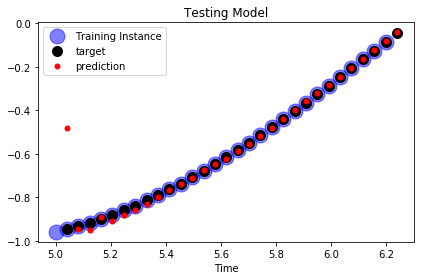

In [54]:
# New data
X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
y_pred = sess.run(outputs, feed_dict={X: X_new})
plt.title("Testing Model")
# Training Instance
plt.plot(train_inst[:-1], np.sin(
    train_inst[:-1]), "bo", markersize=15,alpha=0.5, label="Training Instance")
# Target to Predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")
# Models Prediction
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()

## GENERATE NEW DATA

Text(0, 0.5, 'Value')

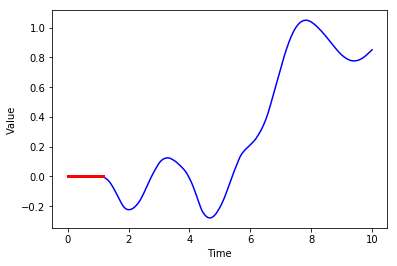

In [55]:
# SEED WITH ZEROS
zero_seq_seed = [0. for i in range(num_time_steps)]
for iteration in range(len(ts_data.x_data) - num_time_steps):
    X_batch = np.array(
        zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
    y_pred = sess.run(outputs, feed_dict={X: X_batch})
    zero_seq_seed.append(y_pred[0, -1, 0])

plt.plot(ts_data.x_data, zero_seq_seed, "b-")
plt.plot(ts_data.x_data[:num_time_steps], 
         zero_seq_seed[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

Text(0.5, 0, 'Time')

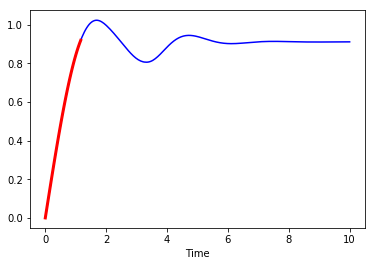

In [56]:
# SEED WITH Training Instance
training_instance = list(ts_data.y_true[:30])
for iteration in range(len(ts_data.x_data) -num_time_steps):
    X_batch = np.array(
        training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
    y_pred = sess.run(outputs, feed_dict={X: X_batch})
    training_instance.append(y_pred[0, -1, 0])
        
plt.plot(ts_data.x_data, training_instance, "b-")
plt.plot(ts_data.x_data[:num_time_steps],
         training_instance[:num_time_steps], "r-", linewidth=3)
plt.xlabel("Time")

In [58]:
# Close session
sess.close()